# Exercise Set 13: Network formation


In this Exercise Set 13 we will investigate network formation among high school pupils. 

## Part 1: Network formation


Load the data using the script below. Read a bit about the dataset [here](http://www.sociopatterns.org/datasets/high-school-contact-and-friendship-networks/) to get an understanding of what is in each variable. 

The script gives you two dataframes to work with: 
 > `el`, which is an edge-list 
 >
 > `ind` which contains individual characteristics

In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline
plt.style.use('ggplot')

url_base = 'http://www.sociopatterns.org/wp-content/uploads/2015/'

# edgelist
url_el = url_base + '07/High-School_data_2013.csv.gz'
col_names_el = ['timestamp', 'u1', 'u2', 'class1', 'class2']
el = pd.read_csv(url_el, header=None, names=col_names_el, delimiter=' ')

# individual characteristics
url_ind = url_base + '09/metadata_2013.txt'
col_names_ind = ['u', 'class', 'gender']
ind = pd.read_csv(url_ind, header=None, names=col_names_ind, delimiter='\t')\
            .set_index('u')

# remove observation with missing gender
has_gender = ind[ind.gender!='Unknown'].index

# DataFrames
ind = ind.loc[has_gender].copy()
el = el[el.u1.isin(has_gender) &  el.u2.isin(has_gender)].copy()

/Users/Esben/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
ind.head()

,class,gender
u,,
650,2BIO1,F
498,2BIO1,F
627,2BIO1,F
857,2BIO1,F
487,2BIO1,F


In [3]:
el.head()

,timestamp,u1,u2,class1,class2
0,1385982020,454,640,MP,MP
1,1385982020,1,939,2BIO3,2BIO3
2,1385982020,185,258,PC*,PC*
3,1385982020,55,170,2BIO3,2BIO3
4,1385982020,9,453,PC,PC


> **Ex. 13.1.1**: Describe the edgelist columns content. Parse the timestamp. What is the resolution of meetings? Use the parsed timestamp to count the meetings by hour in local time.

**Answer 13.1.1**: The edgelist (el) represents the active contacts during 20-second intervals of the data collection (column = 'timestamp'). Each row has the form “[timestamp, u1, u2, class1, class2]“, where u1 and u2 are the anonymous IDs of the persons in contact, class1 and class2 are their classes, and the interval during which this contact was active is [timestamp – 20s, timestamp ] (That is, the denoted timestamp marks the end of the given 20second-interval). If multiple contacts are active in a given interval, multiple lines start with the same value of t. Time is measured in seconds and expressed in UNIX ctime.

Text(0.5, 0, 'Date and time')

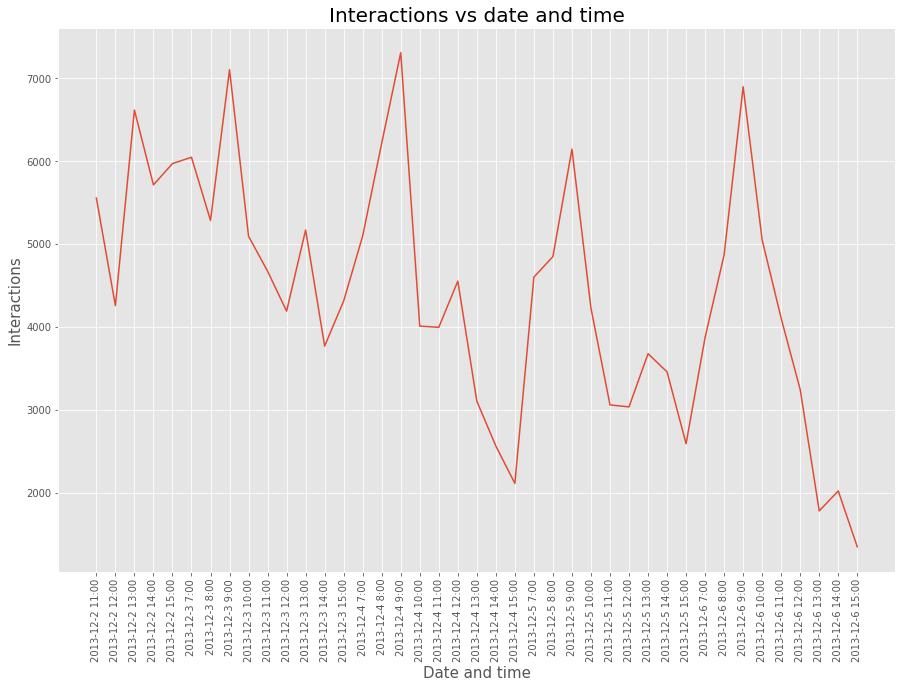

In [4]:
#Convert timestamp to datetime
el['date'] = pd.to_datetime(el['timestamp'],unit='s')

# Plot date and time 
fig, ax = plt.subplots(1,1,figsize = (15,10))

g = el.groupby([el.date.dt.year, el.date.dt.month ,el.date.dt.day, el.date.dt.hour]).timestamp.count()
ax = g.plot()
ax.set_xticks(range(len(g)));
ax.set_xticklabels(["%04d-%02d-%d %d:00" % item for item in g.index.tolist()], rotation=90)

plt.title('Interactions vs date and time', size = 20)
plt.ylabel('Interactions', size = 15)
plt.xlabel('Date and time', size = 15)

> **Ex. 13.1.2**: Count the number of meetings for each edge and save this as a DataFrame called `el_agg`. Filter out edges with less than 5 minutes of meetings. Attach the gender and class of both nodes.

In [5]:
#Count interactions for each edge
el_agg = el.groupby(['u1','u2']).size()
el_agg = el_agg.reset_index().rename(columns = {0:'meet_count'})
#5min is 300s, so they would have to have met for more than 15 times (15*20s = 300s). 
el_agg = el_agg[el_agg.meet_count >= 15]
# Merge gender and class
el_agg = el_agg.merge(ind.add_suffix('_u1'), left_on = 'u1', right_on = 'u')
el_agg = el_agg.merge(ind.add_suffix('_u2'), left_on = 'u2', right_on = 'u')
print(el_agg.shape)
el_agg.head()

(1375, 7)


,u1,u2,meet_count,class_u1,gender_u1,class_u2,gender_u2
0,1,117,18,2BIO3,M,2BIO3,M
1,39,117,27,2BIO3,F,2BIO3,M
2,55,117,26,2BIO3,F,2BIO3,M
3,101,117,44,2BIO3,F,2BIO3,M
4,106,117,104,2BIO3,F,2BIO3,M


> **Ex. 13.1.3**: Answer question in the function `fraction_triangles` below. Explain how `fraction_triangles` is related to  computing the clustering coefficient (using `nx.average_clustering`).
>
>> *Hint:* The following code does the same thing as `fraction_triangles`, but at a scale where you can understand what's going on. If you have a hard time understanding the code in the function you can try to play around with this simpler example
>>
>> ```python
>> import networkx as nx 
>>
>> A  = np.array(
>>     [[0, 1, 1, 0],
>>      [1, 0, 1, 0],
>>      [1, 1, 0, 1],
>>      [0, 0, 1, 0]]
>> )
>>
>> G = nx.from_numpy_array(A)
>> nx.draw(G,with_labels=True)
>>
>> def nth(A, n):
>>     A_ = A.copy()    
>>     for _ in range(1,n):
>>         A = A.dot(A_)
>>     return A
>>
>> a_t = nth(A,3).diagonal().sum()/6
>> n = len(A[:,0])
>> p_t = binom(n, 3)
>> ```


In [6]:
def make_net(el_, nodes):
    '''
    Convert edgelist to networkx graph which is 
    binary and undirected.
    
    Parameters
    ----------
    el_ : DataFrame
        Table containing an edgelist with columns 
        `u1` and `u2` which are the nodes in the edge.
        
    nodes : array-like
        1d array containing the node identities.
    '''    
    
    nx_input = el_, 'u1', 'u2', 'meet_count', nx.Graph()
    g = nx.from_pandas_edgelist(*nx_input)
    g.add_nodes_from(nodes)
    return g

In [7]:
from scipy.special import binom

def fraction_triangles(el_, nodes):
    '''
    Compute fraction of actual triangles out 
    of the potential triangles.
    
    Parameters
    ----------
    el_ : DataFrame
        Table containing an edgelist with columns 
        `u1` and `u2` which are the nodes in the edge.
        
    nodes : array-like
        1d array containing the node identities.
    '''
    
    g = make_net(el_, nodes)
    
    #Q.1: what is `A`?: the adjacency matrix which is symmetric and binary
    #Q.2: what does `A**3` do? compute the number of paths between two nodes
    #Q.3: what is diagonal of A_t? the number of actual paths of length 3, 
    # i.e. triangles, which include the person. these are called cycles
    # because they start and end at the same person
    
    # count actual triangles = paths of length 3 that starts and end at the same person  
    A = nx.to_scipy_sparse_matrix(g)
    A_t = A**3
    a_t = A_t.diagonal().sum()/6 
    
    #Q.4: what does `binom(n,3)` compute? the number of triangles including the person
    
    # count potential triangles
    n = len(g.nodes())
    p_t = binom(n, 3) #potential triangles - paths of lenth 3, which starts and stop at the same person
        
    return a_t/p_t # return the fraction of actualized triangles (actual divided by potential)

> **Ex. 13.1.4**: Apply the function `fraction_triangles` to `el_agg` and print the triangle fraction in the network. Next remove all edges that go between classes. Compute triangle fraction within each class and store it. Compute the mean within class triangles and bootstrap the standard error of the mean. Comment on the output.
>
>> *Hint:* To bootstrap an estimate draw $k>>0$ samples with replacement from the data. Compute the estimate on each of these samples and average them in the end to get the bootstrapped estimate. 

In [8]:
el_agg

,u1,u2,meet_count,class_u1,gender_u1,class_u2,gender_u2
0,1,117,18,2BIO3,M,2BIO3,M
1,39,117,27,2BIO3,F,2BIO3,M
2,55,117,26,2BIO3,F,2BIO3,M
3,101,117,44,2BIO3,F,2BIO3,M
4,106,117,104,2BIO3,F,2BIO3,M
...,...,...,...,...,...,...,...
1370,1332,1819,120,MP*2,F,MP*2,M
1371,1423,1819,62,MP*2,M,MP*2,M
1372,1594,1819,129,MP*2,F,MP*2,M
1373,1332,1870,21,MP*2,F,MP*2,M


In [9]:
#rename since 'class' is reserved for another function --> ind.class will fail
ind.rename(columns = {'class':'class_x'}, inplace = True)

#Remove between-class edges
el_within_classes = el_agg[el_agg.class_u1 == el_agg.class_u2].copy()

#Def funtion to calculate the average triangles for each classes
def average_class_tria(unique_classes,
                       nodes_list):
    #Container for class fraction
    class_frac = pd.DataFrame(columns = ['tria_frac'])

    for _class in unique_classes: #Loop through classes
        in_class = nodes_list[nodes_list.class_x == _class] # Get nodes in the class 
        edges_in_class = el_within_classes[el_within_classes.class_u1 == _class] # Get edges in class
        #Calc fraction - append to container df
        class_frac.loc[_class,'tria_frac'] = fraction_triangles(edges_in_class, in_class)
    #Reset index 
    class_frac.reset_index(inplace=True)
    return class_frac


def bootstrap_error(class_df, k, fraction, column = 'tria_frac'):
    errors = []
    for _ in range(k):
        errors.append(class_df.sample(frac = fraction, replace = True)[column].sem())
    boot_std = sum(errors)/len(errors)

    return boot_std

In [10]:
class_frac = average_class_tria(ind['class_x'].unique(), ind)
std = bootstrap_error(class_frac, 50, 0.5)
print("Triangle fraction in total (between classes): %.8f" % fraction_triangles(el_agg, ind.index.values))
print('Mean within class triangels: %.8f' % class_frac.mean())
print('The bootstrap std. error estimate: %.8f' % std)

Triangle fraction in total (between classes): 0.00030149
Mean within class triangels: 0.01964621
The bootstrap std. error estimate: 0.00351162


**Answer 13.1.4**: We can see that the students tend to befriend (or cluster with) their classmates, rather than their year group (årgang, ik). This is not a surprise though, as the number of potential triangles becomes much, much larger, when we do not restrict to classmembers. Furthermore, we see that the std. error is significantly low (compared to the estimated mean) to assume that the difference between in-class- and overall-triangles is not due to noise or coinsidence (***kan man godt sige det egentlig? Kan man snakke om statistisk signifikans, t-værdier, p-værdier osv? Hvor H0 ville være at triangle fraction er det samme in-class som i 'overall'?***). 

Recall from class that we can define the following measures of homophily. We define **homophily index** inspired by [Currarini et al. (2009)](https://doi.org/10.2139/ssrn.1021650):
- share of edges that are same type: $H = \frac{s}{s+d}$
- possible range [0,1]


We define **baseline homophily** as: 
- We count fraction of potential edges in population of nodes which are same type:

\begin{equation}B=\frac{\sum_t\#potential(n_t)}{\#potential(n)}, \qquad \#potential(k)=\frac{k\cdot(k-1)}{2}\end{equation}

- Interpretation: Expected homophily from random link formation.     

We define **inbreeding homophily** as:      

\begin{equation}IH=\frac{H-B}{1-B}\end{equation}


> **Ex. 13.1.5**: Compute the inbreeding homophily for each class. Use the class measures to compute the mean. Use a bootstrap to compute whether there is inbreeding homophily.

In [11]:
# _class = the class we want to examine for inbreeding homophily
# df = the dataframe the edges are in. 
def inbreed_hom_gender(_class, df):
    
    _class_df = df[df.class_u1 == _class] # get edges from _class
    s = _class_df.gender_u1.eq(_class_df.gender_u2).sum() # same type edges
    d = _class_df.gender_u1.ne(_class_df.gender_u2).sum() # different type edges
    
    H = s/(s+d) # Calculate homophily
    
    def potential(k): # k = number of nodes of same type 
        return (k*(k-1))/2
    
    #Get nodes from the class
    node_type_df = ind[ind.class_x == _class]
    #Get the gendertypes - don't want to assume anything
    genders = node_type_df.gender.unique()
    #extract number of observation of each type - make into a list
    gender_dist = [sum(node_type_df.gender==gender) for gender in genders]
    #Call potential(k) for each type = expected homophily from random link formation
    B = sum([potential(n) for n in gender_dist])/potential(len(node_type_df))
            
    return (H-B)/(1-B)

In [12]:
##################### Calculate inbreeding homo for the classes ###################
#Container
class_homo = pd.DataFrame(columns = ['inbreeding_homo'])

for _class in ind['class_x'].unique(): #Loop through classes
    class_homo.loc[_class,'inbreeding_homo'] = inbreed_hom_gender(_class, el_within_classes)

In [13]:
print(class_homo)
print('Average inbreeding homophily %.8f' % class_homo['inbreeding_homo'].mean())
print('Bootstraped standard errors %.8f' % bootstrap_error(class_homo,
                                                           k = 50,
                                                           fraction = 0.5,
                                                           column = 'inbreeding_homo'))

      inbreeding_homo
2BIO1       0.0194954
2BIO2        0.184297
2BIO3        0.029182
MP*1        0.0327576
MP*2       -0.0207702
PSI*        0.0486919
PC           0.107941
PC*          0.297598
MP           0.295139
Average inbreeding homophily 0.11048123
Bootstraped standard errors 0.05530668


**Answer**: It would appear that there is inbreeding homophily within the classes. 

> **Ex. 13.1.6** (BONUS): Describe what an unsupported edge is. Construct a test of whether there is a preference for forming  triangles within same gender than across.
>
>> *Hint:*  You can find inspiration in the approach of [Chandrasekhar, Jackson (2018)](https://web.stanford.edu/~arungc/CJ_sugm.pdf) pp. 31-35. They construct an almost identical test for triangle formation across castes in Indian villages.

In [14]:
# [Answer to ex. 13.1.6 here]